   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

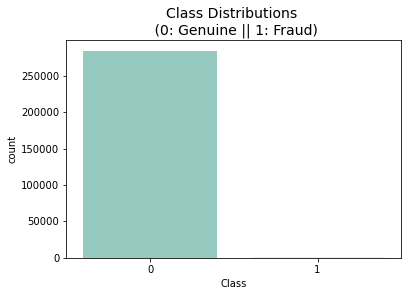

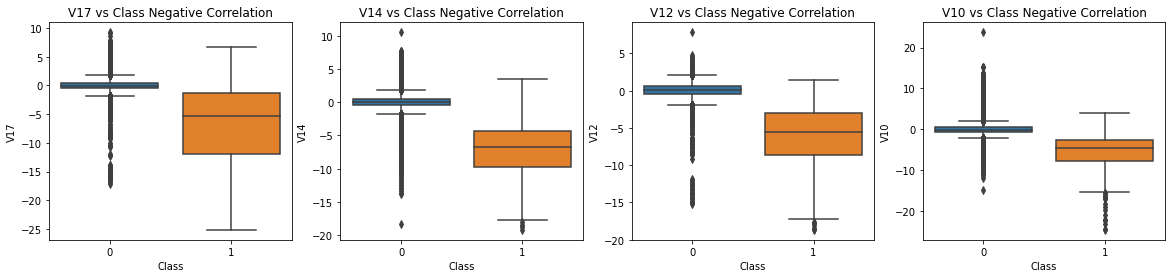

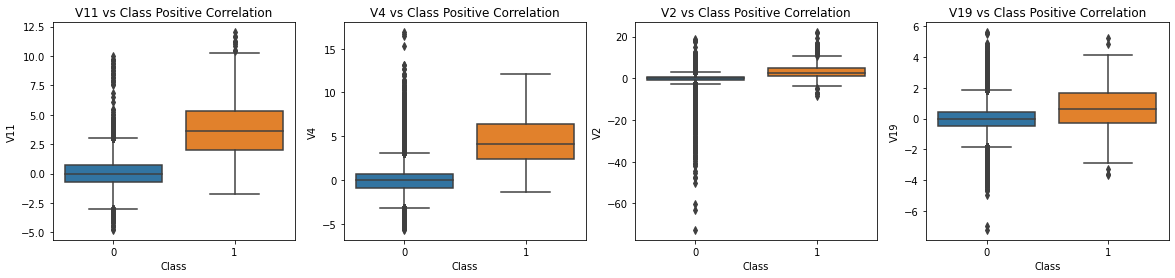

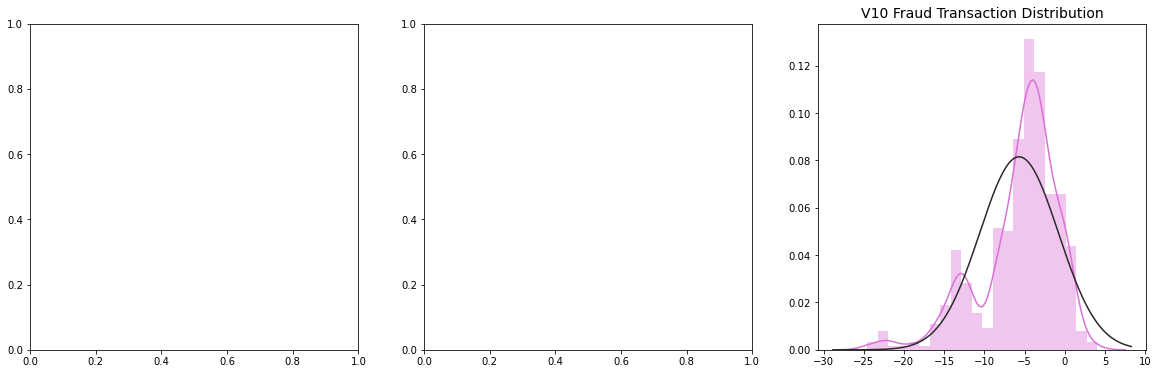

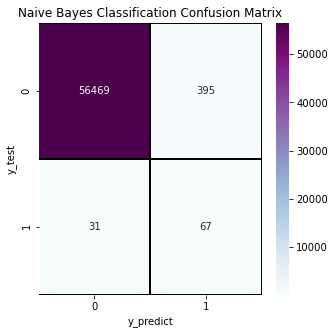

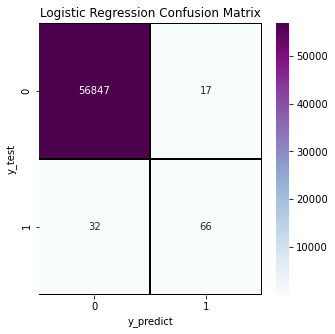

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf 
from sklearn.decomposition import PCA 
from sklearn import preprocessing

# Models libraries 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
import collections 

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from scipy.stats import norm

# Read data
data = pd.read_csv('data/creditcard.csv')
print(data.head())

# Check the data 
print("Credit card Fraud Detection data contains rows:", data.shape[0], "columns:", data.shape[1])


# Visulazing data 
sns.countplot('Class', data=data, palette="Set3")
plt.title('Class Distributions \n (0: Genuine || 1: Fraud)', fontsize=14)


# # Learn more about PSA variable by checking the distribution and correlations 
# fig, ax = plt.subplots(1,2,figsize=(18,4))
# amount_value = data['Amount'].values
# time_value = data['Time'].values

# sns.distplot(amount_value, ax=ax[0], color = 'g')
# ax[0].set_title("Distribution of Transaction amount", fontsize=14)
# ax[0].set_xlim([min(amount_value), max(amount_value)])

# sns.distplot(time_value, ax=ax[1], color = 'b')
# ax[1].set_title("Distribution of Transaction time", fontsize=14)
# ax[1].set_xlim([min(time_value), max(time_value)])

# Feature selection - by creating a drop list
drop_list_1 = ['V28','V27','V26','V25','V24','V23','V22', 'V20', 'V15', 'V13']
drop_list_2 = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']


# Trying to split data so that it is more balanced 

# Split data into training, validation, test set
def split_data(data, drop_list):
    data = data.drop(drop_list, axis=1)
    y = data["Class"].values # our labels
    X = data.drop(["Class"] ,axis=1).values # our features
    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state=42, stratify=y) 
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42, stratify=y)
    print("The number of fraud in test-set: ", sum(y_test))
    print("The size of training set : ", len(y_train),"\nThe size of test set: ", len(y_test))
    return X_train, X_test, y_train, y_test


# Get our training, validation, test set
X_train_1, X_test_1, y_train_1, y_test_1 = split_data(data, drop_list_1)
X_train_2, X_test_2, y_train_2, y_test_2 = split_data(data, drop_list_2)
#X_train_3, X_test_3, y_train_3, y_test_3 = split_data(data, drop_list_3)

# Correlation matrices 
# Variables with negative correlation
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=data, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=data, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=data, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=data, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

# Variables with positive correlation
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=data, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=data, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=data, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=data, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')


# Anomaly Detection to remove outliers 
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = data['V14'].loc[data['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='lightsalmon')
ax1.set_title('V14 Fraud Transaction Distribution ', fontsize=14)

v12_fraud_dist = data['V12'].loc[data['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='powderblue')
ax2.set_title('V12 Fraud Transaction Distribution', fontsize=14)


v10_fraud_dist = data['V10'].loc[data['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='orchid')
ax3.set_title('V10 Fraud Transaction Distribution', fontsize=14)

# remove outliers 

# Classification methods 
# Use Naive Bayes for our data
naive_bayes = GaussianNB()
# Training data 
naive_bayes.fit(X_train_1,y_train_1)
# Predict data 
y_pred_naive = naive_bayes.predict(X_test_1)

# Logistic Regression
log_reg = LogisticRegression(max_iter = 490)
log_reg.fit(X_train_2,y_train_2)
y_pred_log_reg = log_reg.predict(X_test_2)

# Supporting Vector Machine 
#svm = SVC(kernel= "rbf")
#svm.fit(X_train_3, y_train_3)
#y_pred_svm = svm.predict(X_train_3)
#print(y_pred_svm)


# Try GridSearch CV 


# Get the accuracy of our training data 
#accuracy_train = accuracy_score(y_train, naive_bayes.predict(X_train))
#accuracy_test = accuracy_score(y_test, y_pred)

#print("Accuracy training set is ", accuracy_train)
#print("Accuracy testing set is ", accuracy_test)

# Print scores 
def print_scores(y_test,y_pred):
    print('The confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    
print("Naive Bayes Gaussian Distribution results: ")
print_scores(y_test_1, y_pred_naive)
print("Logistics Regression results: ")
print_scores(y_test_2, y_pred_log_reg)
#print_scores(y_train_3, y_pred_svm)

# Get confusion matrix 
naive_bayes_confusion = confusion_matrix(y_test_1, y_pred_naive)
log_reg_confusion = confusion_matrix(y_test_2, y_pred_log_reg)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(naive_bayes_confusion, annot=True, linewidth=0.7, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Naive Bayes Classification Confusion Matrix')
plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.show()
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(log_reg_confusion, annot=True, linewidth=0.7, linecolor='black', fmt='g', ax=ax, cmap="BuPu")
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('y_predict')
plt.ylabel('y_test')
plt.show()



# Look at xgboost and lightgbm 